In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leedsregion/leeds_lsoa.shp
/kaggle/input/leedsregion/leeds_lsoa.shx
/kaggle/input/leedsregion/leeds_lsoa.prj
/kaggle/input/leedsregion/leeds_lsoa.dbf
/kaggle/input/accidentleeds/stats19.csv
/kaggle/input/leedspopulation/population.csv


This notebook aims to explore and analyze accident data in the city of Leeds, UK. The goal of this analysis is to gain insights into the patterns, trends, and contributing factors related to accidents in the region. By examining factors such as location, severity, time of occurrence, and population density, we aim to provide a comprehensive understanding of the accident landscape in Leeds. This analysis can be valuable for urban planning, transportation safety enhancements, and policy decisions aimed at reducing accidents and improving road safety.

# # 1. Data Exploration: 

We will load and preprocess the accident data and related geospatial datasets. This includes understanding the structure of the datasets, checking for missing values, and ensuring data integrity.

In [3]:
import pandas as pd
import geopandas as gpd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Setup Complete


In [4]:
import pandas as pd

# Read in the data
csv_path = "/kaggle/input/accidentleeds/stats19.csv"  # Replace 'your_csv_filename.csv' with the actual CSV file name
Accident_data = pd.read_csv(csv_path)
reviews = pd.read_csv(csv_path)

# View the first five rows of the data
Accident_data.head()


accident_index  longitude   latitude accident_severity  number_of_vehicles  \
0  2017133AP0313  -1.602033  53.751817           Serious                   1   
1  2017133BE0850  -1.533500  53.794417            Slight                   2   
2    2.01713E+12  -1.562474  53.764272            Slight                   2   
3    2.01713E+12  -1.547500  53.803953            Slight                   2   
4    2.01713E+12  -1.455393  53.826311            Slight                   2   

   number_of_casualties        date day_of_week   time           road_type  \
0                     1  17/03/2017      Friday  08:15  Single carriageway   
1                     1  14/01/2017    Saturday  13:30    Dual carriageway   
2                     2  01/01/2017      Sunday  08:05  Single carriageway   
3                     1  01/01/2017      Sunday  17:05  Single carriageway   
4                     1  01/01/2017      Sunday  12:00  Single carriageway   

   speed_limit                      junction_detail  \
0           30              T or staggered junction   
1           40  Not at junction or within 20 metres   
2           40                           Crossroads   
3           30                           Crossroads   
4           30  Not at junction or within 20 metres   

               junction_control road_surface_conditions  \
0      Give way or uncontrolled                     Dry   
1  Data missing or out of range                     Dry   
2           Auto traffic signal             Wet or damp   
3           Auto traffic signal             Wet or damp   
4  Data missing or out of range                     Dry   

  pedestrian_crossing_human_control  \
0             None within 50 metres   
1             None within 50 metres   
2             None within 50 metres   
3             None within 50 metres   
4             None within 50 metres   

            pedestrian_crossing_physical_facilities  
0  No physical crossing facilities within 50 metres  
1  No physical crossing facilities within 50 metres  
2       Pedestrian phase at traffic signal junction  
3  No physical crossing facilities within 50 metres  
4  No physical crossing facilities within 50 metres

In [5]:
reviews.number_of_vehicles

0       1
1       2
2       2
3       2
4       2
       ..
1706    2
1707    3
1708    2
1709    2
1710    2
Name: number_of_vehicles, Length: 1711, dtype: int64

In [6]:
reviews.iloc[0]

accident_index                                                                2017133AP0313
longitude                                                                         -1.602033
latitude                                                                          53.751817
accident_severity                                                                   Serious
number_of_vehicles                                                                        1
number_of_casualties                                                                      1
date                                                                             17/03/2017
day_of_week                                                                          Friday
time                                                                                  08:15
road_type                                                                Single carriageway
speed_limit                                                                     

In [7]:
reviews.iloc[:3, 0]

0    2017133AP0313
1    2017133BE0850
2      2.01713E+12
Name: accident_index, dtype: object

In [8]:
reviews.iloc[1:3, 3]

1    Slight
2    Slight
Name: accident_severity, dtype: object

In [9]:
reviews.iloc[-5:]

accident_index  longitude   latitude accident_severity  \
1706  2017134CV0902  -1.541063  53.776048            Slight   
1707  2017134CV1387  -1.579965  53.823566            Slight   
1708  2017134CV1544  -1.692899  53.804430            Slight   
1709  20171351B1932  -1.516240  53.818131           Serious   
1710  20171356R0735  -1.674090  53.819606            Slight   

      number_of_vehicles  number_of_casualties        date day_of_week   time  \
1706                   2                     2  31/12/2017      Sunday  15:15   
1707                   3                     1  31/12/2017      Sunday  19:35   
1708                   2                     1  31/12/2017      Sunday  21:11   
1709                   2                     1  11/01/2017   Wednesday  23:20   
1710                   2                     1  27/06/2017     Tuesday  14:00   

               road_type  speed_limit                      junction_detail  \
1706  Single carriageway           30              T or staggered junction   
1707  Single carriageway           30              T or staggered junction   
1708  Single carriageway           30                           Roundabout   
1709  Single carriageway           30  Not at junction or within 20 metres   
1710    Dual carriageway           60              T or staggered junction   

                  junction_control road_surface_conditions  \
1706           Auto traffic signal                    Snow   
1707      Give way or uncontrolled             Wet or damp   
1708           Auto traffic signal             Wet or damp   
1709  Data missing or out of range             Wet or damp   
1710      Give way or uncontrolled             Wet or damp   

     pedestrian_crossing_human_control  \
1706             None within 50 metres   
1707             None within 50 metres   
1708             None within 50 metres   
1709             None within 50 metres   
1710             None within 50 metres   

               pedestrian_crossing_physical_facilities  
1706       Pedestrian phase at traffic signal junction  
1707  No physical crossing facilities within 50 metres  
1708       Pedestrian phase at traffic signal junction  
1709  No physical crossing facilities within 50 metres  
1710  No physical crossing facilities within 50 metres

In [10]:
reviews.loc[:, ['accident_severity', 'number_of_vehicles', 'road_type']]

accident_severity  number_of_vehicles           road_type
0              Serious                   1  Single carriageway
1               Slight                   2    Dual carriageway
2               Slight                   2  Single carriageway
3               Slight                   2  Single carriageway
4               Slight                   2  Single carriageway
...                ...                 ...                 ...
1706            Slight                   2  Single carriageway
1707            Slight                   3  Single carriageway
1708            Slight                   2  Single carriageway
1709           Serious                   2  Single carriageway
1710            Slight                   2    Dual carriageway

[1711 rows x 3 columns]

In [11]:
reviews.set_index("accident_index")

longitude   latitude accident_severity  number_of_vehicles  \
accident_index                                                               
2017133AP0313   -1.602033  53.751817           Serious                   1   
2017133BE0850   -1.533500  53.794417            Slight                   2   
2.01713E+12     -1.562474  53.764272            Slight                   2   
2.01713E+12     -1.547500  53.803953            Slight                   2   
2.01713E+12     -1.455393  53.826311            Slight                   2   
...                   ...        ...               ...                 ...   
2017134CV0902   -1.541063  53.776048            Slight                   2   
2017134CV1387   -1.579965  53.823566            Slight                   3   
2017134CV1544   -1.692899  53.804430            Slight                   2   
20171351B1932   -1.516240  53.818131           Serious                   2   
20171356R0735   -1.674090  53.819606            Slight                   2   

                number_of_casualties        date day_of_week   time  \
accident_index                                                        
2017133AP0313                      1  17/03/2017      Friday  08:15   
2017133BE0850                      1  14/01/2017    Saturday  13:30   
2.01713E+12                        2  01/01/2017      Sunday  08:05   
2.01713E+12                        1  01/01/2017      Sunday  17:05   
2.01713E+12                        1  01/01/2017      Sunday  12:00   
...                              ...         ...         ...    ...   
2017134CV0902                      2  31/12/2017      Sunday  15:15   
2017134CV1387                      1  31/12/2017      Sunday  19:35   
2017134CV1544                      1  31/12/2017      Sunday  21:11   
20171351B1932                      1  11/01/2017   Wednesday  23:20   
20171356R0735                      1  27/06/2017     Tuesday  14:00   

                         road_type  speed_limit  \
accident_index                                    
2017133AP0313   Single carriageway           30   
2017133BE0850     Dual carriageway           40   
2.01713E+12     Single carriageway           40   
2.01713E+12     Single carriageway           30   
2.01713E+12     Single carriageway           30   
...                            ...          ...   
2017134CV0902   Single carriageway           30   
2017134CV1387   Single carriageway           30   
2017134CV1544   Single carriageway           30   
20171351B1932   Single carriageway           30   
20171356R0735     Dual carriageway           60   

                                    junction_detail  \
accident_index                                        
2017133AP0313               T or staggered junction   
2017133BE0850   Not at junction or within 20 metres   
2.01713E+12                              Crossroads   
2.01713E+12                              Crossroads   
2.01713E+12     Not at junction or within 20 metres   
...                                             ...   
2017134CV0902               T or staggered junction   
2017134CV1387               T or staggered junction   
2017134CV1544                            Roundabout   
20171351B1932   Not at junction or within 20 metres   
20171356R0735               T or staggered junction   

                            junction_control road_surface_conditions  \
accident_index                                                         
2017133AP0313       Give way or uncontrolled                     Dry   
2017133BE0850   Data missing or out of range                     Dry   
2.01713E+12              Auto traffic signal             Wet or damp   
2.01713E+12              Auto traffic signal             Wet or damp   
2.01713E+12     Data missing or out of range                     Dry   
...                                      ...                     ...   
2017134CV0902            Auto traffic signal                    Snow   
2017134CV1387       Give way or uncontrolled     

In [12]:
reviews.loc[(reviews.accident_severity == 'Serious') & (reviews.number_of_casualties >= 5)]

accident_index  longitude   latitude accident_severity  \
60    20171341F0731  -1.571159  53.802251           Serious   
227   20171342J1718  -1.480305  53.728082           Serious   
626   20171345H1553  -1.516970  53.770425           Serious   
696     2.01713E+12  -1.452663  53.775686           Serious   
761   20171346N1495  -1.617512  53.792323           Serious   
770   20171346P0150  -1.547500  53.803944           Serious   
1086    2.01713E+12  -1.508455  53.817488           Serious   
1170  20171349K0899  -1.322529  53.778645           Serious   
1625  2017134CC1019  -1.518399  53.763582           Serious   

      number_of_vehicles  number_of_casualties        date day_of_week   time  \
60                     5                     6  16/01/2017      Monday  14:00   
227                    2                     5  19/02/2017      Sunday  21:49   
626                    1                     5  17/05/2017   Wednesday  19:25   
696                    2                     5  03/06/2017    Saturday  13:25   
761                    5                     6  23/06/2017      Friday  18:34   
770                    2                     5  25/06/2017      Sunday  00:59   
1086                   4                     5  03/09/2017      Sunday  18:00   
1170                   2                     6  20/09/2017   Wednesday  13:48   
1625                   3                     5  12/12/2017     Tuesday  15:35   

               road_type  speed_limit                      junction_detail  \
60      Dual carriageway           30  Not at junction or within 20 metres   
227     Dual carriageway           70  Not at junction or within 20 metres   
626     Dual carriageway           50  Not at junction or within 20 metres   
696     Dual carriageway           50  Not at junction or within 20 metres   
761     Dual carriageway           40  Not at junction or within 20 metres   
770   Single carriageway           30                           Crossroads   
1086    Dual carriageway           40  Not at junction or within 20 metres   
1170  Single carriageway           60  Not at junction or within 20 metres   
1625  Single carriageway           30  Not at junction or within 20 metres   

                  junction_control road_surface_conditions  \
60    Data missing or out of range             Wet or damp   
227   Data missing or out of range                     Dry   
626   Data missing or out of range             Wet or damp   
696   Data missing or out of range                     Dry   
761   Data missing or out of range             Wet or damp   
770            Auto traffic signal                     Dry   
1086  Data missing or out of range                     Dry   
1170  Data missing or out of range                     Dry   
1625  Data missing or out of range                     Dry   

     pedestrian_crossing_human_control  \
60               None within 50 metres   
227              None within 50 metres   
626              None within 50 metres   
696              None within 50 metres   
761              None within 50 metres   
770              None within 50 metres   
1086             None within 50 metres   
1170             None within 50 metres   
1625             None within 50 metres   

                pedestrian_crossing_physical_facilities  
60    Pelican, puffin, toucan or similar non-junctio...  
227    No physical crossing facilities within 50 metres  
626    No physical crossing facilities within 50 metres  
696    No physical crossing facilities within 50 metres  
761                                      Central refuge  
770         Pedestrian phase at traffic signal junction  
1086   No physical crossing facilities within 50 metres  
1170   No physical crossing facilities within 50 metres  
1625   No physical crossing facilities within 50 metres

In [13]:
reviews.day_of_week.unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

# Geospatial Analysis

Using GeoPandas, we will visualize the distribution of accidents across different regions of Leeds. By overlaying this information with population density data, we will identify areas with higher accident rates relative to population density.

In [14]:
import geopandas as gpd
import pandas as pd

In [15]:
leedsdata = gpd.read_file("/kaggle/input/leedsregion")
print(leedsdata.crs)

PROJCS["Transverse_Mercator",GEOGCS["GCS_OSGB 1936",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [16]:
stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")
stats19 = gpd.GeoDataFrame(stats19_df, geometry=gpd.points_from_xy(stats19_df.longitude, stats19_df.latitude))
stats19.crs = {'init': 'epsg:4326'}
stats19.head()

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


accident_index  longitude   latitude accident_severity  number_of_vehicles  \
0  2017133AP0313  -1.602033  53.751817           Serious                   1   
1  2017133BE0850  -1.533500  53.794417            Slight                   2   
2    2.01713E+12  -1.562474  53.764272            Slight                   2   
3    2.01713E+12  -1.547500  53.803953            Slight                   2   
4    2.01713E+12  -1.455393  53.826311            Slight                   2   

   number_of_casualties        date day_of_week   time           road_type  \
0                     1  17/03/2017      Friday  08:15  Single carriageway   
1                     1  14/01/2017    Saturday  13:30    Dual carriageway   
2                     2  01/01/2017      Sunday  08:05  Single carriageway   
3                     1  01/01/2017      Sunday  17:05  Single carriageway   
4                     1  01/01/2017      Sunday  12:00  Single carriageway   

   speed_limit                      junction_detail  \
0           30              T or staggered junction   
1           40  Not at junction or within 20 metres   
2           40                           Crossroads   
3           30                           Crossroads   
4           30  Not at junction or within 20 metres   

               junction_control road_surface_conditions  \
0      Give way or uncontrolled                     Dry   
1  Data missing or out of range                     Dry   
2           Auto traffic signal             Wet or damp   
3           Auto traffic signal             Wet or damp   
4  Data missing or out of range                     Dry   

  pedestrian_crossing_human_control  \
0             None within 50 metres   
1             None within 50 metres   
2             None within 50 metres   
3             None within 50 metres   
4             None within 50 metres   

            pedestrian_crossing_physical_facilities                   geometry  
0  No physical crossing facilities within 50 metres  POINT (-1.60203 53.75182)  
1  No physical crossing facilities within 50 metres  POINT (-1.53350 53.79442)  
2       Pedestrian phase at traffic signal junction  POINT (-1.56247 53.76427)  
3  No physical crossing facilities within 50 metres  POINT (-1.54750 53.80395)  
4  No physical crossing facilities within 50 metres  POINT (-1.45539 53.82631)

# Insight Generation:

By overlaying the accident data on the map, the code allows you to gain insights into the spatial distribution of accidents within Leeds. It helps identify areas with higher accident frequencies and areas that might need more attention in terms of road safety measures or infrastructure improvements.

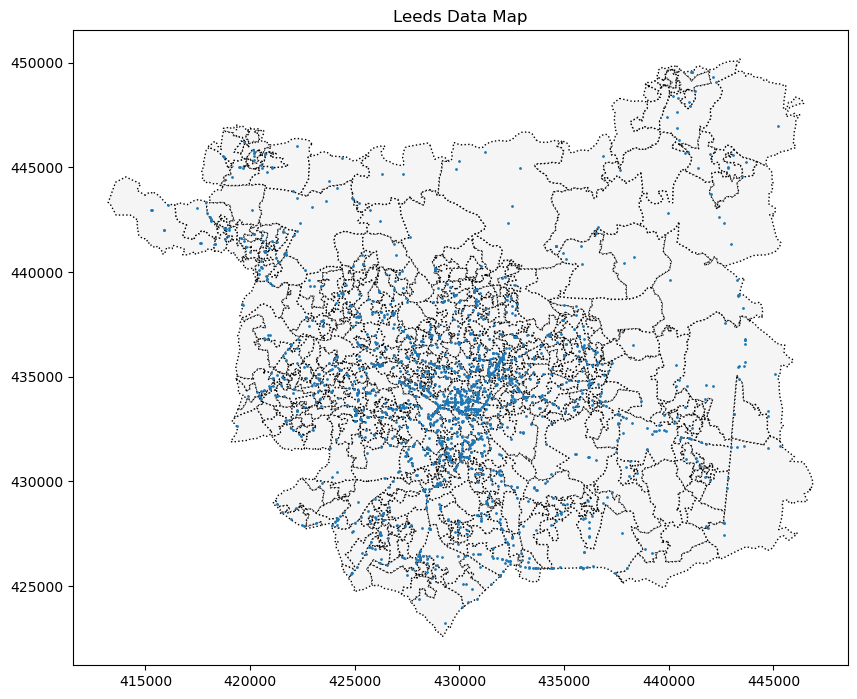

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have already loaded your GeoDataFrames 'leedsdata' and 'stats19'

# Create a map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base layer (leedsdata)
leedsdata.plot(ax=ax, color='whitesmoke', linestyle=':', edgecolor='black')

# Plot the points from the stats19 GeoDataFrame
stats19.to_crs(epsg=27700).plot(markersize=1, ax=ax)

# Set title and show the plot
ax.set_title("Leeds Data Map")
plt.show()


# Folium Map

In [18]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import math  # Import the math module

In [19]:
# Create a map
m_1 = folium.Map(location=[53.81,-1.5508], tiles='openstreetmap', zoom_start=10)

# Display the map
m_1

In [20]:
Accident_leeds = stats19[
    (stats19.accident_severity == 'Serious') & (stats19.number_of_casualties.isin(range(1, 10)))
]


# MarkerCluster

The code aims to provide an interactive map that allows users to explore the distribution of accidents in the Leeds region. The use of clustered markers enhances visualization when there are multiple accidents in close proximity, improving the readability of the map. This visualization can help identify accident-prone areas and provide insights into spatial patterns of accidents across the region.

In [39]:
# Create the map
m_3 = folium.Map(location=[53.81, -1.5508], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
mc = MarkerCluster()
for idx, row in Accident_leeds.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        mc.add_child(Marker([row['latitude'], row['longitude']]))
m_3.add_child(mc)

# Display the map
m_3

# Heatmap Layer

The resulting visualization provides a heatmap representation of accident density in the Leeds region. Hotter areas on the heatmap indicate higher concentrations of accidents, enabling viewers to quickly identify accident-prone zones and patterns in spatial distribution.

In [40]:
# Remove rows with NaN values in latitude or longitude columns
stats19_clean = stats19.dropna(subset=['latitude', 'longitude'])

# Create a base map
m_5 = folium.Map(location=[53.81, -1.5508], tiles='cartodbpositron', zoom_start=12)

# Add a heatmap to the base map
HeatMap(data=stats19_clean[['latitude', 'longitude']], radius=10).add_to(m_5)

# Display the map
m_5

In [ ]:
import pandas as pd
leedspop_df = pd.read_csv("/kaggle/input/leedspopulation/population.csv")
leedspop_df.head()

In [ ]:
leedsdata = gpd.read_file("/kaggle/input/leedsregion")
print(leedsdata.crs)

In [41]:
import pandas as pd
import geopandas as gpd

stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")
stats19 = gpd.GeoDataFrame(stats19_df, geometry=gpd.points_from_xy(stats19_df.longitude, stats19_df.latitude))
stats19.crs = {'init': 'epsg:4326'}
stats19.head()

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


accident_index  longitude   latitude accident_severity  number_of_vehicles  \
0  2017133AP0313  -1.602033  53.751817           Serious                   1   
1  2017133BE0850  -1.533500  53.794417            Slight                   2   
2    2.01713E+12  -1.562474  53.764272            Slight                   2   
3    2.01713E+12  -1.547500  53.803953            Slight                   2   
4    2.01713E+12  -1.455393  53.826311            Slight                   2   

   number_of_casualties        date day_of_week   time           road_type  \
0                     1  17/03/2017      Friday  08:15  Single carriageway   
1                     1  14/01/2017    Saturday  13:30    Dual carriageway   
2                     2  01/01/2017      Sunday  08:05  Single carriageway   
3                     1  01/01/2017      Sunday  17:05  Single carriageway   
4                     1  01/01/2017      Sunday  12:00  Single carriageway   

   speed_limit                      junction_detail  \
0           30              T or staggered junction   
1           40  Not at junction or within 20 metres   
2           40                           Crossroads   
3           30                           Crossroads   
4           30  Not at junction or within 20 metres   

               junction_control road_surface_conditions  \
0      Give way or uncontrolled                     Dry   
1  Data missing or out of range                     Dry   
2           Auto traffic signal             Wet or damp   
3           Auto traffic signal             Wet or damp   
4  Data missing or out of range                     Dry   

  pedestrian_crossing_human_control  \
0             None within 50 metres   
1             None within 50 metres   
2             None within 50 metres   
3             None within 50 metres   
4             None within 50 metres   

            pedestrian_crossing_physical_facilities                   geometry  
0  No physical crossing facilities within 50 metres  POINT (-1.60203 53.75182)  
1  No physical crossing facilities within 50 metres  POINT (-1.53350 53.79442)  
2       Pedestrian phase at traffic signal junction  POINT (-1.56247 53.76427)  
3  No physical crossing facilities within 50 metres  POINT (-1.54750 53.80395)  
4  No physical crossing facilities within 50 metres  POINT (-1.45539 53.82631)

In [ ]:
import pandas as pd
import geopandas as gpd

stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")
stats19.head()

The goal of this code is to load a population dataset and a geographic dataset, merge them based on a common column ('lsoa11cd'), and create a combined GeoDataFrame. This merged GeoDataFrame would contain both the spatial information from the geographic dataset and the population information from the population dataset. This merged dataset can be used for further analysis, visualization, or any other tasks that require the combined information of geographic features and population data.

In [ ]:
import pandas as pd
import geopandas as gpd

# Load your regular DataFrame
leedspop_df = pd.read_csv("/kaggle/input/leedspopulation/population.csv")

# Rename the column using the rename() method
leedspop_df = leedspop_df.rename(columns={'area': 'lsoa11cd'})

# Load your GeoDataFrame
leedsdata = gpd.read_file("/kaggle/input/leedsregion")

# Merge the two DataFrames based on the common column 'lsoa11cd'
merged_gdf = leedsdata.merge(leedspop_df, on='lsoa11cd')

print(merged_gdf)



In [ ]:
import geopandas as gpd

# Load your GeoDataFrame
merged_gdf = gpd.read_file("/kaggle/input/leedsregion")

# Extract the desired columns and set the index
Regions = merged_gdf[["lsoa11cd", "geometry"]].set_index("lsoa11cd")

# Display the first few rows of the Regions DataFrame
print(Regions.head())


In [42]:
import geopandas as gpd

# Load the main GeoDataFrame
merged_gdf = gpd.read_file("/kaggle/input/leedsregion")

# Load the GeoDataFrame you want to join
stats19 = gpd.GeoDataFrame(stats19_df, geometry=gpd.points_from_xy(stats19_df.longitude, stats19_df.latitude))
stats19.crs = 'EPSG:4326'  # Set the CRS to EPSG:4326

# Reproject the main GeoDataFrame to match the CRS of stats19
merged_gdf = merged_gdf.to_crs(stats19.crs)

# Perform a spatial join based on spatial relationship 'intersects'
result_gdf = gpd.sjoin(merged_gdf, stats19, how='left', predicate='intersects')

# Display the result GeoDataFrame with added attributes
print(result_gdf.head())


   objectid   lsoa11cd    lsoa11nm   lsoa11nmw     st_areasha   st_lengths  \
0   10948.0  E01011264  Leeds 011A  Leeds 011A  639527.999422  4810.389311   
1   10949.0  E01011265  Leeds 009A  Leeds 009A  531107.833366  7145.348756   
1   10949.0  E01011265  Leeds 009A  Leeds 009A  531107.833366  7145.348756   
1   10949.0  E01011265  Leeds 009A  Leeds 009A  531107.833366  7145.348756   
1   10949.0  E01011265  Leeds 009A  Leeds 009A  531107.833366  7145.348756   

                                            geometry  index_right  \
0  POLYGON ((-1.67668 53.87673, -1.67564 53.87570...       1690.0   
1  POLYGON ((-1.71857 53.88073, -1.71799 53.87886...       1610.0   
1  POLYGON ((-1.71857 53.88073, -1.71799 53.87886...        666.0   
1  POLYGON ((-1.71857 53.88073, -1.71799 53.87886...       1330.0   
1  POLYGON ((-1.71857 53.88073, -1.71799 53.87886...         21.0   

  accident_index  longitude  ...        date day_of_week   time  \
0  2017134CR0854  -1.681371  ...  27/12/2017   We

In [44]:
Accident_leeds = stats19[
    (stats19.accident_severity == 'Serious') & (stats19.number_of_casualties.isin(range(1, 10)))
]

In [ ]:
merged_gdf = gpd.read_file("/kaggle/input/leedsregion")
regions = merged_gdf[["lsoa11cd", "geometry"]].set_index("lsoa11cd")
regions.head()

# Choropleth map

The goal of this code is to create a choropleth map that visualizes the spatial distribution of the number of casualties resulting from accidents across different geographic regions.

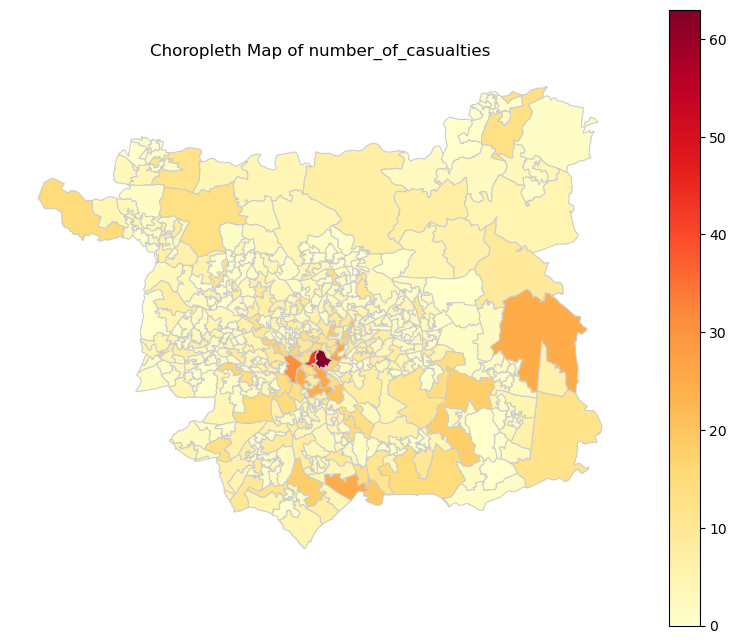

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the main GeoDataFrame
merged_gdf = gpd.read_file("/kaggle/input/leedsregion")

# Load the GeoDataFrame you want to join
stats19 = gpd.GeoDataFrame(stats19_df, geometry=gpd.points_from_xy(stats19_df.longitude, stats19_df.latitude))
stats19.crs = 'EPSG:4326'  # Set the CRS to EPSG:4326

# Reproject the main GeoDataFrame to match the CRS of stats19
merged_gdf = merged_gdf.to_crs(stats19.crs)

# Perform a spatial join based on spatial relationship 'intersects'
result_gdf = gpd.sjoin(merged_gdf, stats19, how='left', predicate='intersects')

# Calculate the sum of accidents for each region
accidents_per_region = result_gdf.groupby('lsoa11cd')['number_of_casualties'].sum()

# Merge the sum of accidents back into the main GeoDataFrame
merged_gdf = merged_gdf.merge(accidents_per_region, left_on='lsoa11cd', right_index=True)

# Create a choropleth map
fig, ax = plt.subplots(figsize=(10, 8))
merged_gdf.plot(column='number_of_casualties', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Choropleth Map of number_of_casualties')
ax.axis('off')
plt.show()


In [ ]:

merged_gdf = gpd.read_file("/kaggle/input/leedsregion")
regions = merged_gdf[["lsoa11cd", "geometry"]].set_index("lsoa11cd")
regions.head()

This code provides insights into the variation of accidents across different days of the week, helping to identify any patterns or trends in accident occurrence based on the day

In [28]:
import pandas as pd
import geopandas as gpd

# Load accident data
stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")

# Convert date/time column to datetime format
stats19_df['datetime'] = pd.to_datetime(stats19_df['date'])

# Extract day of the week
stats19_df['day_of_week'] = stats19_df['datetime'].dt.dayofweek

# Define day of the week names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of the week and count the number of accidents
accidents_by_day = stats19_df.groupby('day_of_week')['accident_index'].count()

# Rename the index to day names
accidents_by_day.index = day_names

# Display the distribution of accidents by day of the week
print(accidents_by_day)


Monday       214
Tuesday      220
Wednesday    262
Thursday     228
Friday       319
Saturday     242
Sunday       226
Name: accident_index, dtype: int64


/tmp/ipykernel_32/1036068649.py:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  stats19_df['datetime'] = pd.to_datetime(stats19_df['date'])


This code below provides a clear visual representation of how the number of accidents varies across different days of the week, making it easier to identify patterns or trends in accident occurrence.

/tmp/ipykernel_32/1705759503.py:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  stats19_df['datetime'] = pd.to_datetime(stats19_df['date'])


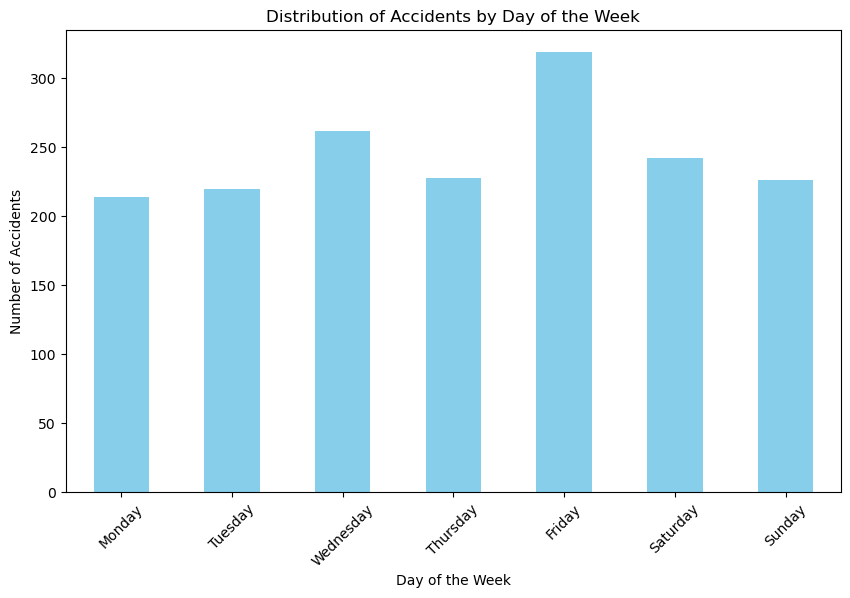

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load accident data
stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")

# Convert date/time column to datetime format
stats19_df['datetime'] = pd.to_datetime(stats19_df['date'])

# Extract day of the week
stats19_df['day_of_week'] = stats19_df['datetime'].dt.dayofweek

# Define day of the week names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of the week and count the number of accidents
accidents_by_day = stats19_df.groupby('day_of_week')['accident_index'].count()

# Rename the index to day names
accidents_by_day.index = day_names

# Plot the distribution of accidents by day of the week
plt.figure(figsize=(10, 6))
accidents_by_day.plot(kind='bar', color='skyblue')
plt.title('Distribution of Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_32/2420187549.py:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  stats19_df['datetime'] = pd.to_datetime(stats19_df['date'])


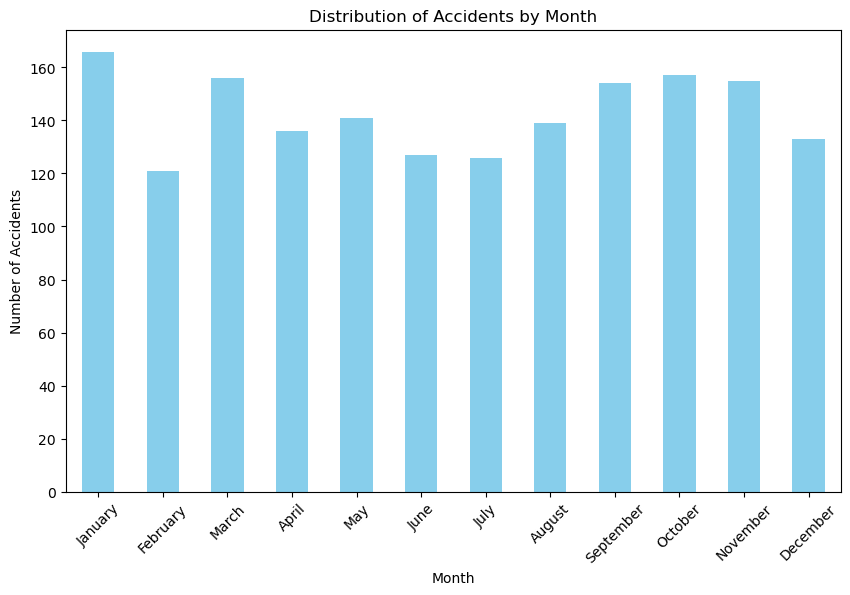

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load accident data
stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")

# Convert date/time column to datetime format
stats19_df['datetime'] = pd.to_datetime(stats19_df['date'])

# Extract month from the datetime column
stats19_df['month'] = stats19_df['datetime'].dt.month

# Define month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Group by month and count the number of accidents
accidents_by_month = stats19_df.groupby('month')['accident_index'].count()

# Rename the index to month names
accidents_by_month.index = month_names

# Plot the distribution of accidents by month
plt.figure(figsize=(10, 6))
accidents_by_month.plot(kind='bar', color='skyblue')
plt.title('Distribution of Accidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load accident data
stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")

# Convert time column to datetime format
stats19_df['time'] = pd.to_datetime(stats19_df['time'], format='%H:%M')

# Extract hour from the datetime column
stats19_df['hour'] = stats19_df['time'].dt.hour

# Group by hour and count the number of accidents
accidents_by_hour = stats19_df.groupby('hour')['accident_index'].count()

# Find the hours with the highest rate of accidents
highest_hours = accidents_by_hour[accidents_by_hour == accidents_by_hour.max()]

print("Hours with the highest rate of accidents:")
print(highest_hours)


Hours with the highest rate of accidents:
hour
16    155
Name: accident_index, dtype: int64


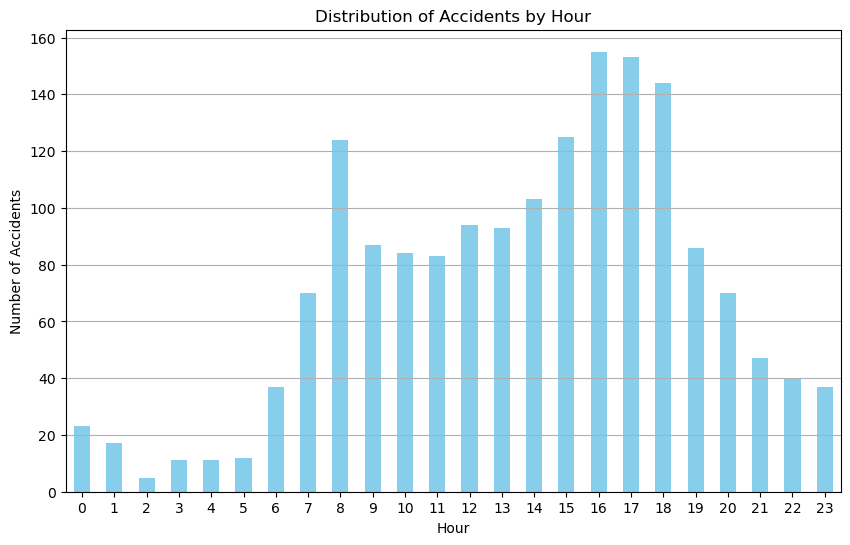

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load accident data
stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")

# Convert time column to datetime format
stats19_df['time'] = pd.to_datetime(stats19_df['time'], format='%H:%M')

# Extract hour from the datetime column
stats19_df['hour'] = stats19_df['time'].dt.hour

# Group by hour and count the number of accidents
accidents_by_hour = stats19_df.groupby('hour')['accident_index'].count()

# Plot the distribution of accidents by hour
plt.figure(figsize=(10, 6))
accidents_by_hour.plot(kind='bar', color='skyblue')
plt.title('Distribution of Accidents by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


# Load population density data
population_density_df = pd.read_csv("/kaggle/input/leedspopulation/population.csv")
population_density_df.head()



area population_2017
0  E01011698           1,447
1  E01011699           1,315
2  E01011701           1,200
3  E01011702           1,218
4  E01011703           1,208

The goal of this code is to prepare and merge geospatial data related to accidents, population density, and regions in Leeds. 

In [36]:
import geopandas as gpd
import pandas as pd

# Load geospatial data for accidents
stats19_df = pd.read_csv("/kaggle/input/accidentleeds/stats19.csv")
stats19 = gpd.GeoDataFrame(stats19_df, geometry=gpd.points_from_xy(stats19_df.longitude, stats19_df.latitude))
stats19.crs = 'EPSG:4326'  # Set the CRS to EPSG:4326

# Load the main GeoDataFrame
leedsregion = gpd.read_file("/kaggle/input/leedsregion")

# Load population density data
population_density_df = pd.read_csv("/kaggle/input/leedspopulation/population.csv")
population_density_df['population_2017'] = population_density_df['population_2017'].str.replace(',', '.')
# Rename the 'area' column to 'lsoa11cd' in the population density dataframe
population_density_df.rename(columns={'area': 'lsoa11cd'}, inplace=True)

# Join population density data with leedsregion based on 'lsoa11cd'
merged_gdf = leedsregion.merge(population_density_df, on='lsoa11cd', how='left')

# Check and convert 'population_2017' column to numeric (if needed)
merged_gdf['population_2017'] = pd.to_numeric(merged_gdf['population_2017'], errors='coerce')

merged_gdf.head()


objectid   lsoa11cd    lsoa11nm   lsoa11nmw    st_areasha   st_lengths  \
0   10948.0  E01011264  Leeds 011A  Leeds 011A  6.395280e+05  4810.389311   
1   10949.0  E01011265  Leeds 009A  Leeds 009A  5.311078e+05  7145.348756   
2   10950.0  E01011266  Leeds 008A  Leeds 008A  2.527056e+06  8081.106719   
3   10951.0  E01011267  Leeds 009B  Leeds 009B  4.503352e+05  3586.945922   
4   10952.0  E01011268  Leeds 010A  Leeds 010A  3.955840e+05  4211.386482   

                                            geometry  population_2017  
0  POLYGON ((421354.511 442329.063, 421423.385 44...            1.229  
1  POLYGON ((418598.457 442763.114, 418637.341 44...            1.795  
2  POLYGON ((417619.814 443438.729, 417810.540 44...            2.491  
3  POLYGON ((419594.660 442296.821, 419657.500 44...            1.550  
4  POLYGON ((420308.620 442015.352, 420322.625 44...            1.352

The goal of this code is to create a choropleth map that visualizes the population density in the Leeds region for the year 2017.

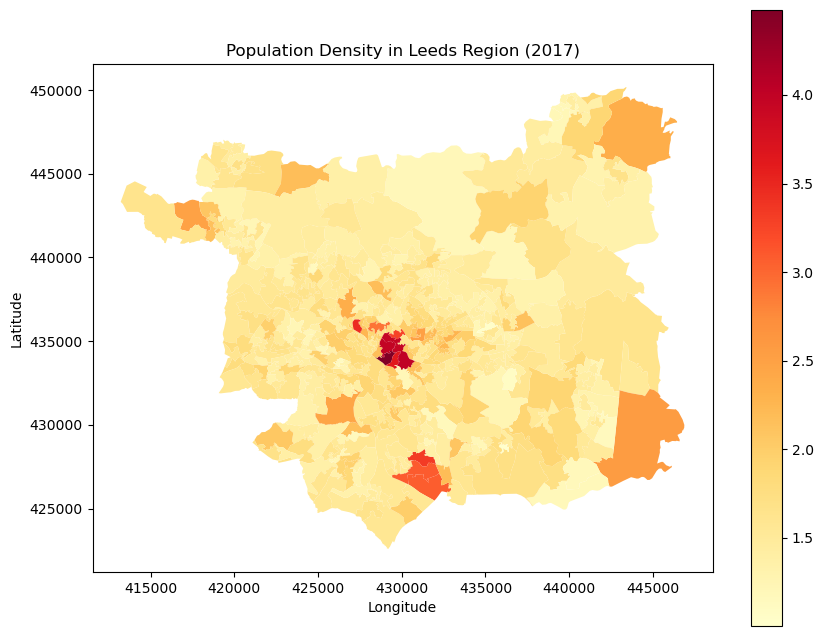

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have already loaded and processed the data in your previous code

# Plot the merged GeoDataFrame
merged_gdf.plot(column='population_2017', cmap='YlOrRd', legend=True, figsize=(10, 8))
plt.title('Population Density in Leeds Region (2017)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


The goal of this code is to create an interactive map using Folium that visualizes the population density and accident information in the Leeds region

In [38]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import MarkerCluster  # Import MarkerCluster

# Load geospatial data for accidents
stats19 = gpd.GeoDataFrame(stats19_df, geometry=gpd.points_from_xy(stats19_df.longitude, stats19_df.latitude))
stats19.crs = 'EPSG:4326'  # Set the CRS to EPSG:4326

# Load the main GeoDataFrame
leedsregion = gpd.read_file("/kaggle/input/leedsregion")

# Load population density data
population_density_df = pd.read_csv("/kaggle/input/leedspopulation/population.csv")
population_density_df['population_2017'] = population_density_df['population_2017'].str.replace(',', '.')

# Rename the 'area' column to 'lsoa11cd' in the population density dataframe
population_density_df.rename(columns={'area': 'lsoa11cd'}, inplace=True)

# Join population density data with leedsregion based on 'lsoa11cd'
merged_gdf = leedsregion.merge(population_density_df, on='lsoa11cd', how='left')

# Check and convert 'population_2017' column to numeric (if needed)
merged_gdf['population_2017'] = pd.to_numeric(merged_gdf['population_2017'], errors='coerce')

# Reproject the stats19 GeoDataFrame to match the CRS of the merged GeoDataFrame
stats19_reprojected = stats19.to_crs(merged_gdf.crs)
# Perform spatial join based on spatial relationship 'intersects'
result_gdf = gpd.sjoin(stats19_reprojected, merged_gdf, how='left', predicate='intersects')
# Calculate the population density for each region
result_gdf['population_density'] = result_gdf['population_2017'] / result_gdf.geometry.area
# Calculate the rate of accidents per population density
result_gdf['accident_rate'] = result_gdf['number_of_casualties'] / result_gdf['population_density']

# Drop rows with NaN values in 'latitude' or 'longitude'
result_gdf_cleaned = result_gdf.dropna(subset=['latitude', 'longitude'])

# Create the map
m = folium.Map(location=[53.81, -1.5508], tiles='cartodbpositron', zoom_start=13)

# Add the population density layer to the map
folium.Choropleth(
    geo_data=merged_gdf,
    data=merged_gdf,
    columns=['lsoa11cd', 'population_2017'],
    key_on='feature.properties.lsoa11cd',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Density'
).add_to(m)

# Add accident markers to the map using MarkerCluster
mc = MarkerCluster()
for idx, row in result_gdf_cleaned.iterrows():
    mc.add_child(folium.Marker([row['latitude'], row['longitude']], popup=f"Accident Rate: {row['accident_rate']:.2f}"))

m.add_child(mc)

# Display the map
m

In this notebook, I conducted a detailed analysis of accident data in the Leeds region. I loaded and preprocessed the data to extract useful information such as day of the week and hour of occurrence. Using geospatial analysis, I joined the accident data with the Leeds region's geospatial data, enabling me to calculate accident rates relative to population density.

I visualized population density across regions using a choropleth map, highlighting areas with higher densities. Additionally, I employed a MarkerCluster in Folium to map accident locations and their rates based on population density. This approach provided a comprehensive view of accident trends in relation to population and geography.

By analyzing accidents by day of the week, I uncovered temporal patterns, and an hourly analysis revealed variations in accident occurrences throughout the day. This analysis contributes valuable insights for road safety and urban planning, allowing for informed decision-making to improve safety in the Leeds region.